In [2]:
from cpclasses import *




In [3]:
def V(x):
    return (-1  -np.exp(-((x+15)/10)**2) \
              -2*np.exp(-((x-10)/10)**2) + \
                -np.exp(-((x-35)/10)**2) \
              -3*np.exp(-((x-60)/10)**2) \
                -np.exp(-((x-85)/10)**2)\
              -2*np.exp(-((x-110)/10)**2) \
              ) * \
            (1+1/5*np.cos(2*np.pi/2.5*x))

In [4]:
potential = CustomPotential(V)

MC_system = MonteCarloSystem(potential)
MC_system.sample_mcmc()
print(MC_system.sample)

[0.         0.09724434 0.15652032 ... 2.79917099 2.75544776 2.75544776]


Text(0, 0.5, 'V(x)')

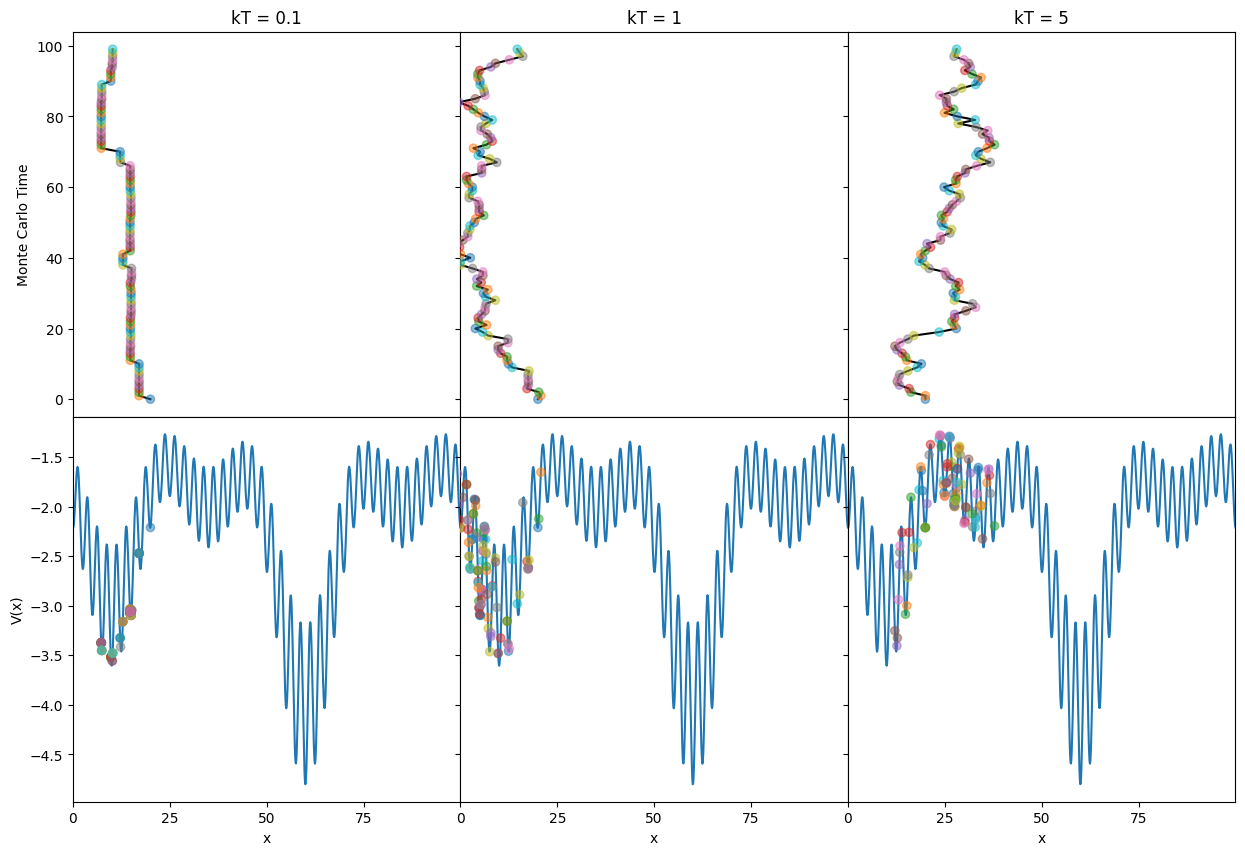

In [44]:
x_range =[0, 100]


kTs = [0.1, 1, 5]

potentials = [CustomPotential(V, x_range=x_range, kT=kT) for kT in kTs]

initial_point = 20
N = 100
fig, axs = plt.subplots(2, len(potentials), figsize = (15, 10), sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, sharex='col')

colors = [f'C{i}' for i in range(N)]
for i, potential, kT in zip(range(len(potentials)), potentials, kTs):
    for ax in axs[:,i]:
        ax.set_xlim(x_range)
        ax.set_xticks(np.arange(x_range[0], x_range[1], 25))


    MC_system = MonteCarloSystem(potential, kT = kT, sample_size=1000, x = initial_point, delta=2)
    MC_system.sample_mcmc(N)

    axs[0,i].plot(MC_system.sample, range(N), color = 'black', zorder = 0)
    axs[0,i].scatter(MC_system.sample, range(N), color = colors, zorder = 10, alpha = 0.5)
    axs[1,i].scatter(MC_system.sample, potential.potential_energy(MC_system.sample), color = colors, zorder = 10, alpha = 0.5)
    potential.plot_V(axs[1,i])
    axs[0,i].set_title(f'kT = {potential.kT}')

axs[1,0].set_xlabel('x')
axs[1,1].set_xlabel('x')
axs[1,2].set_xlabel('x')
axs[0,0].set_ylabel('Monte Carlo Time')
axs[1,0].set_ylabel('V(x)')


In [45]:
save_plot(fig, 'monte_carlo_time')

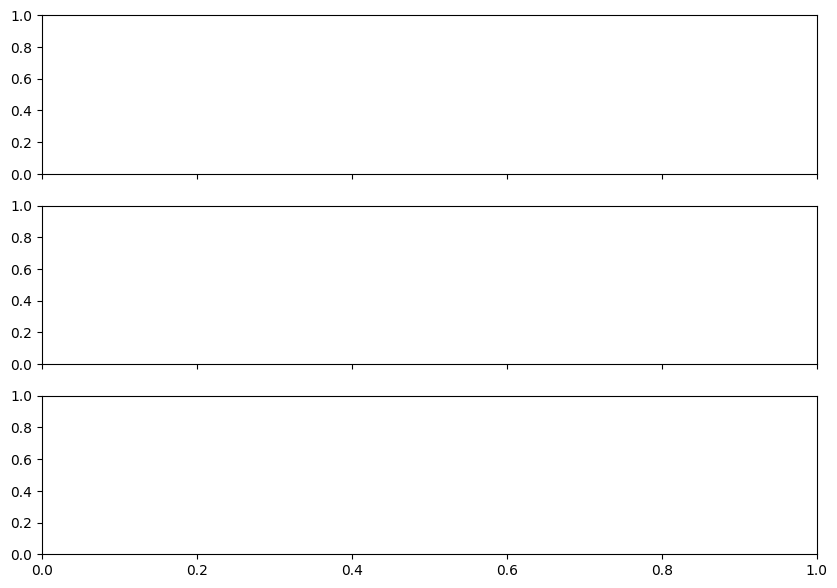

In [108]:


N_walkers = 10

colors = [f'C{i}' for i in range(N_walkers)]
initial_points = np.random.rand(N_walkers) * 100

x_range=  [-0.5, 100]
fig, axs = plt.subplots(3,1, figsize = (10, 7), sharex=True)
ax.set(xlim=(0,100), ylim=(-5, 0))



potential = CustomPotential(V, x_range=x_range)
MC_systems_low = [MonteCarloSystem(potential, kT = 0.15, sample_size=500, x = initial_point, delta=1) for initial_point in initial_points]
MC_systems_med = [MonteCarloSystem(potential, kT = 1, sample_size=500, x = initial_point, delta=1) for initial_point in initial_points]
MC_systems_high = [MonteCarloSystem(potential, kT = 5, sample_size=500, x = initial_point, delta=1) for initial_point in initial_points]

MC_systems = [MC_systems_low, MC_systems_med, MC_systems_high]

for MC_system in MC_systems:
    for MC in MC_system:
        MC.sample_mcmc(500)
    
titles = [f'kT = {0.15}',f'kT = {1}',f'kT = {5}']
def update(i):
    fig.suptitle(f'Monte Carlo Steps {i}')
    for ax, MC_system, title in zip(axs, MC_systems, titles):
        ax.clear()
        ax.set_title(title)
        ax.set(xlim=(0,100), ylim=(-5, 0))
        potential.plot_V(ax)

        points = [(MC.sample[i], potential.V(MC.sample[i])) for MC in MC_system]
        ax.scatter(*zip(*points), color = colors)





from matplotlib.animation import FuncAnimation
#anim = FuncAnimation(fig, update, frames=N, blit=False)
#save_animation(anim, 'Monte_Carlo_walkers, three temps.gif', fps = 25)

In [127]:
N_walkers = 1000
N_steps = 5000

temperatures = [0.004, 0.02, 0.1, 0.5, 2.5]



calculated = False

if calculated == False:
    data_set = {f'{t}': None for t in temperatures}

x_range = [-0.5, 100]
for temperature in temperatures:
    for walker in range(0,N_walkers):
        potential = CustomPotential(V, x_range=x_range, kT=temperature, delta_x=1)
        MC_system = MonteCarloSystem(potential, kT = temperature, sample_size=500, x = np.random.uniform(0, 100), delta=1)
        MC_system.sample_mcmc(N_steps, break_point = -4.75)
        steps_taken = len(MC_system.sample)
        if data_set[f'{temperature}'] is None:
            data_set[f'{temperature}'] = [steps_taken]
        else:
            data_set[f'{temperature}'].append(steps_taken)



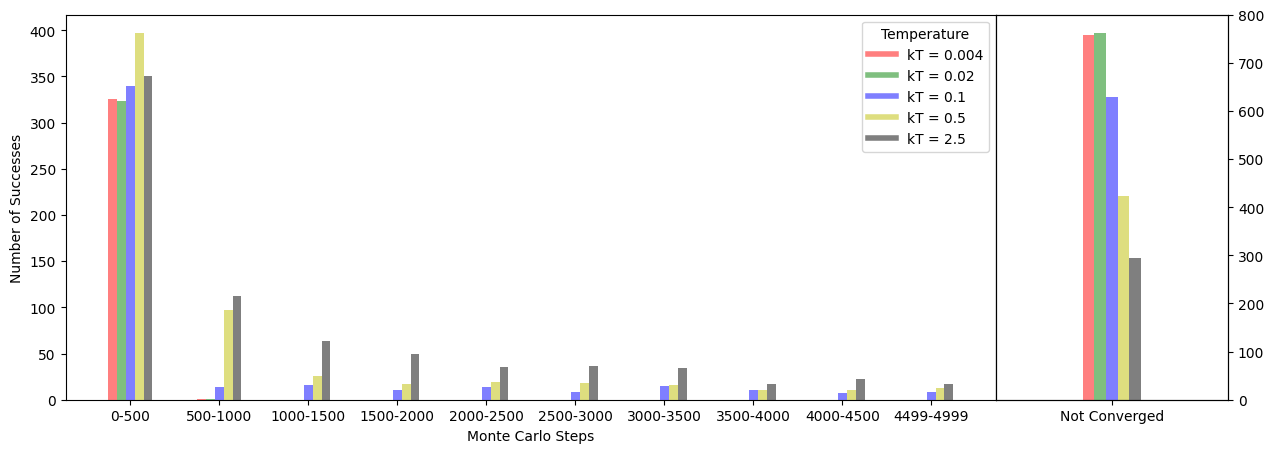

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1,2, figsize = (15, 5), gridspec_kw= {'wspace': 0, 'width_ratios': [4, 1]})



ranges = 500 * np.arange(1,11)
colors = ['r', 'g', 'b', 'y', 'k']
ranges[-1] = 4999 #To remove all the values that are greater than 5000



for temperature, color, i in zip(temperatures, colors, range(len(temperatures))):
    for border in ranges:
        data_temp = np.array(data_set[f'{temperature}'])
        data = np.where(np.logical_and(data_temp > border - 500, data_temp < border))[0]
        
        ax[0].bar(i * 50 + border - 600, len(data), width = 50, color = color, alpha = 0.5)

    data_non_converged = np.where(data_temp >= ranges[-1])[0]
    ax[1].bar(i * 5 + ranges[-1] - 9, len(data_non_converged), width = 5, color = color, alpha = 0.5)
    
labels = [Line2D([0], [0], alpha = 0.5, color= color, lw=4, label= f'kT = {temperature}') for temperature, color in zip(temperatures, colors)]
ax[0].legend(handles=labels, title = 'Temperature', loc = 'upper right')
ax[0].set_xticks(np.arange(0, 5000, 500))
ax[0].set_xticklabels([f'{i - 500}-{i}' for i in ranges])
ax[0].set_xlabel('Monte Carlo Steps')
ax[0].set_ylabel('Number of Successes')

ax[1].set_xticks([5000])
ax[1].set_xticklabels(['Not Converged'])
ax[1].set_xlim(4950, 5050)
ax2 = ax[1].twinx()
ax2.set_yticks(ax[1].get_yticks())
ax[1].set_yticks([])

save_plot(fig, 'monte_carlo_convergence')
    

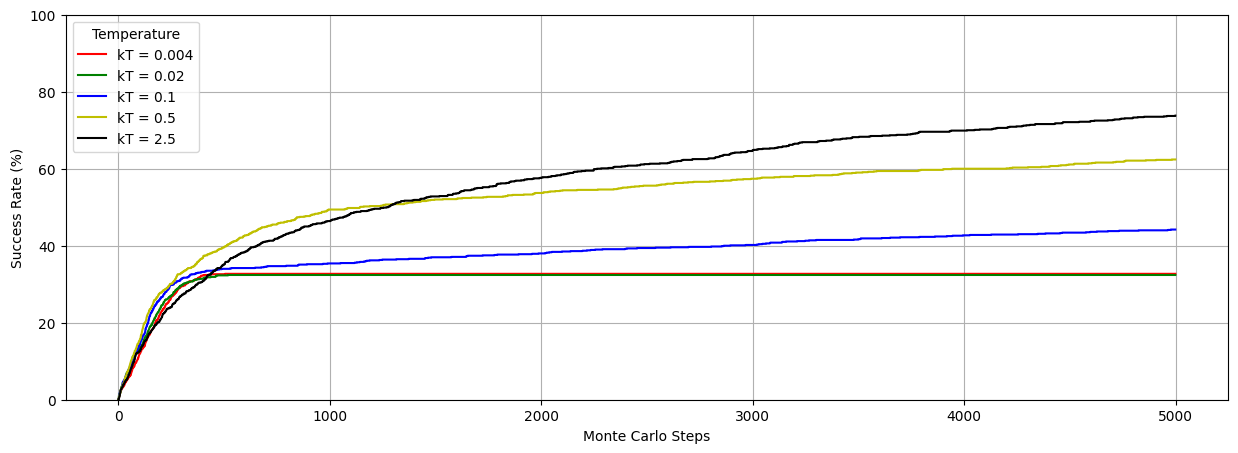

In [139]:
fig,ax = plt.subplots(figsize = (15, 5))


points = np.linspace(0, ranges[-1], 5000)
for temperature, color in zip(temperatures, colors):
    cumulative = np.array([np.sum(data_set[f'{temperature}'] < point) for point in points])
    cumulative_success_rate = cumulative / N_walkers * 100
    ax.plot(points, cumulative_success_rate, color = color, label = f'kT = {temperature}')
ax.legend(title = 'Temperature')
ax.set_xlabel('Monte Carlo Steps')
ax.set_ylabel('Success Rate (%)')
ax.set_ylim(0, 100)
ax.grid()

save_plot(fig, 'monte_carlo_convergence_rate')